# Head direction correlations

In [61]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np

from scipy import signal
from matplotlib.pyplot import figure
from pycircstat.tests import rayleigh

from analysis.models.vr import RatCAVESession
from analysis.models.analytics import direction_preference

In [62]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [63]:
source = '/home/andrey/storage2/andrey/data/processed'
animal = '002431'
session_id = '2019-04-16_10-49-18'

sessionpath = os.path.join(source, animal, session_id)
session = RatCAVESession(sessionpath, alpha=4.3)

session.tetrode_unit_map

{1: [],
 2: [],
 3: [2, 3, 4, 5, 6, 7, 8, 9, 10],
 4: [],
 5: [],
 6: [2, 3, 4, 5, 6, 7, 8, 9],
 7: [],
 8: []}

## Yaw angular distribution

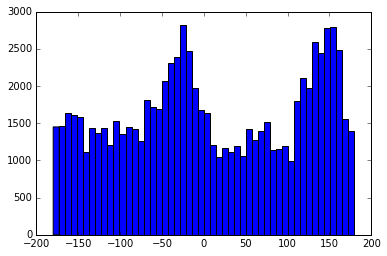

In [64]:
plot = plt.hist(session.trajectory[:, 5], bins=50)

## Yaw evolution during the session

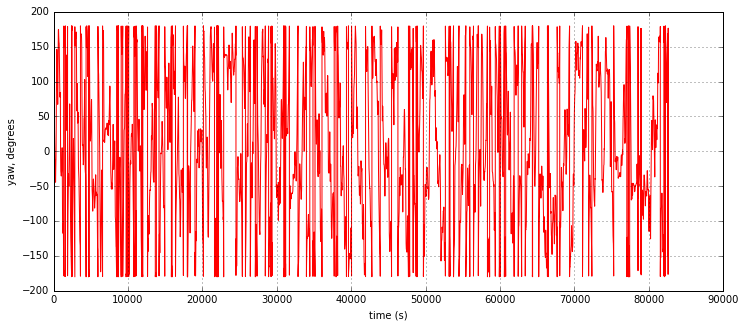

In [65]:
headdir = session.head_direction()
       
fig = figure(figsize=(12, 5))

ax = fig.add_subplot(111)
ax.set_xlabel('time (s)')
ax.set_ylabel('yaw, degrees')
ax.grid(True)

ax.plot(headdir, color='r')

## Neuron direction preference

In [66]:
ttd = 6
unit = 7

headdir = session.head_direction()
firing = session.get_firing_smoothed(ttd, unit)

preference, space = direction_preference(headdir, firing, 180)

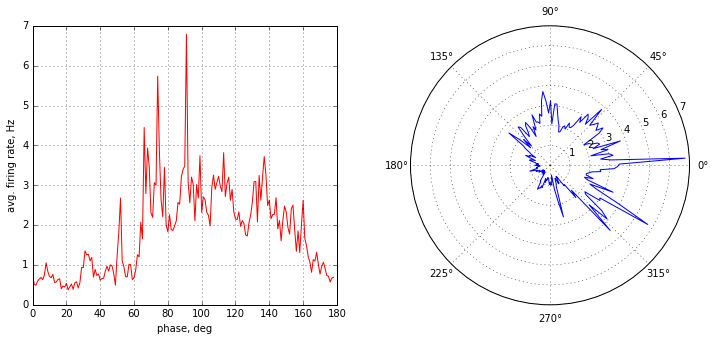

In [67]:
fig = figure(figsize=(12, 5))

ax = fig.add_subplot(121)
ax.set_xlabel('phase, deg')
ax.set_ylabel('avg. firing rate, Hz')
ax.grid(True)
ax.plot(preference, color='r')

ax = fig.add_subplot(122, projection='polar')
ax.plot(space[:-1] * (np.pi/180.), preference)

filename = "ttd_6_unit_7_direction.png"
fig.savefig(os.path.join(source, animal, session_id, 'analysis', filename))

In [14]:
rayleigh(space[:-1] * (np.pi/180.), w=np.array(preference))

(2.0802980626150501e-17, 37.339818823351777)

# Bulk processing

In [57]:
sessions = ['/home/andrey/storage2/andrey/data/processed/002430/2019-02-12_16-43-05',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-13_17-49-29',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-14_11-29-08',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-14_16-34-47',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-15_15-46-05',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-15_21-12-17',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-16_09-39-47',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-16_17-42-46',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-17_15-26-41',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-18_16-17-26',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-19_16-21-36',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-21_22-49-21',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-21_22-52-14',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-22_13-50-30',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-22_15-41-56',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-25_13-06-55',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-26_10-12-17',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-26_15-50-46',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-26_19-54-47',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-27_13-21-54',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-27_22-50-06',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-28_11-21-03',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-03-04_11-58-58']

In [25]:
for i, sessionpath in enumerate(sessions):
    session = RatCAVESession(sessionpath, alpha=4.3)

    headdir = session.head_direction()
    directionfile = os.path.join(sessionpath, 'analysis', 'direction.csv')

    with open(directionfile, 'w') as f:
        header = ', '.join(['ttd', 'unit', 'p_value', 'z score'])
        f.write('# ' + header + '\n')

        for ttd, units in session.tetrode_unit_map.items():
            for unit in units:
                firing = session.get_firing_smoothed(ttd, unit)

                preference, space = direction_preference(headdir, firing, 180)
                p_value, z_score = rayleigh(space[:-1] * (np.pi/180.), w=np.array(preference))

                data = [str(value) for value in [ttd, unit, p_value, z_score]]
                f.write(', '.join(data) + '\n')

    print('\rProcessed %s..' % ((i + 1) / len(sessions)) * 100, end="")

Processed 1.0..5217391304348....

In [58]:
results = []
to_plot = []

for sessionpath in sessions:
    directionfile = os.path.join(sessionpath, 'analysis', 'direction.csv')

    if not os.path.exists(directionfile):
        continue

    unit_head_dir_data = np.loadtxt(directionfile, delimiter=',')
    if unit_head_dir_data.any():
        if len(unit_head_dir_data.shape) > 1:
            results.append(unit_head_dir_data[:, 2].T)
        else:
            results.append([unit_head_dir_data[2]])
           
        if len(unit_head_dir_data.shape) > 1:
            for row in unit_head_dir_data:
                if row[2] < 0.01:
                    to_plot.append((sessionpath, row[0], row[1]))
        else:
            if unit_head_dir_data[2] < 0.01:
                to_plot.append((sessionpath, unit_head_dir_data[0], unit_head_dir_data[1]))
    

/usr/local/lib/python3.5/dist-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "/home/andrey/storage2/andrey/data/processed/002430/2019-02-22_15-41-56/analysis/direction.csv"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)


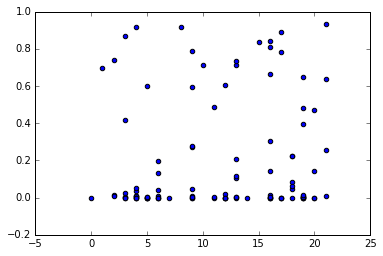

In [59]:
new_res = []

for i, sess in enumerate(results):
    new_res += [(i, value) for value in sess]


nr = np.array(new_res)
plt.scatter(nr[:, 0], nr[:, 1])

In [54]:
space_final = []
preferences = []

for i, datapack in enumerate(to_plot):
    sessionpath, ttd, unit = datapack
    session = RatCAVESession(sessionpath, alpha=4.3)
    
    headdir = session.head_direction()
    firing = session.get_firing_smoothed(ttd, unit)

    preference, space = direction_preference(headdir, firing, 180)
    preferences.append(preference)

space_final = space

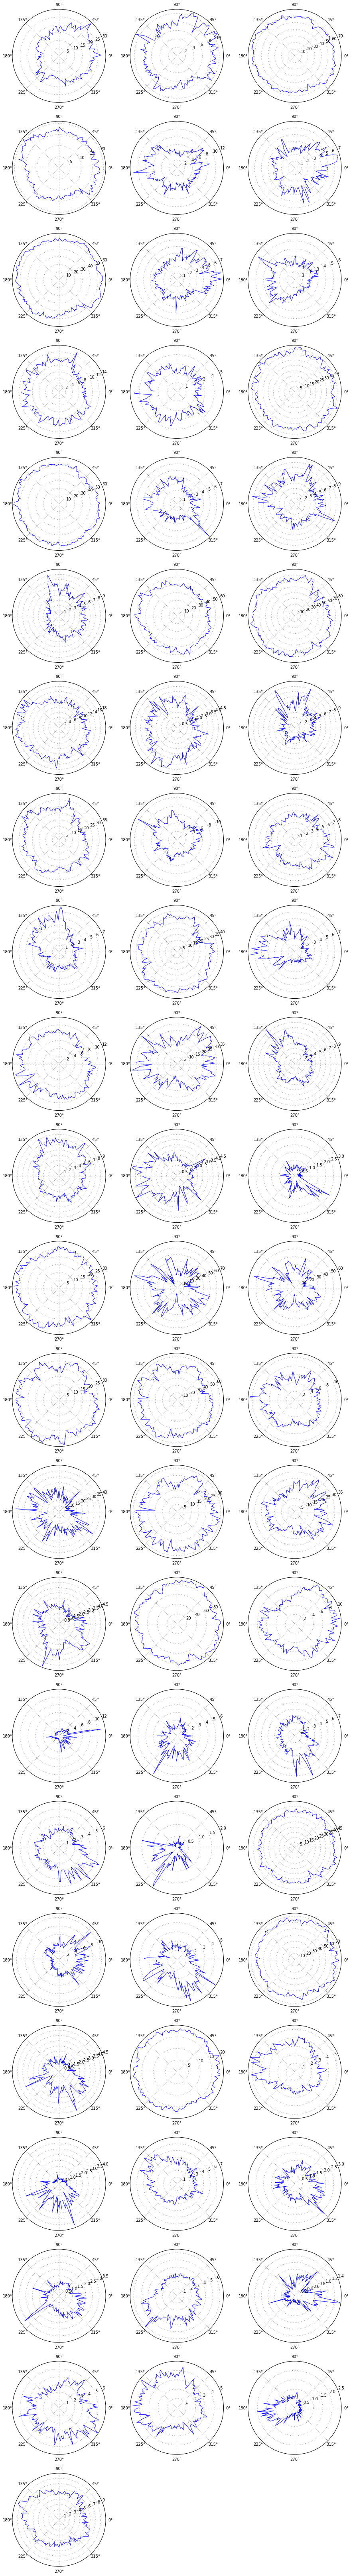

In [55]:
no_x_axes = 3
no_y_axes = np.ceil(len(to_plot) / no_x_axes)

fig = figure(figsize=(int(16 / 3) * no_x_axes, int(16 / 3) * no_y_axes))

for i, preference in enumerate(preferences):
    ax = fig.add_subplot(no_y_axes, no_x_axes, i + 1, projection='polar')
    ax.plot(space[:-1] * (np.pi/180.), preference)